# Health Detector: Using scikit-learn

### 1. Imports

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

In [116]:
def prettyPrint(returnDict):
    print(f'\
            Model: \t\t{returnDict["Model"]}\n\
            R2 Score: \t\t{returnDict["R2 Score"]}\n\
            CV R2 Score: \t{returnDict["CV R2 Score"]}\n\
            MAE: \t\t{returnDict["MAE"]}\n\
            RMSE: \t\t{returnDict["RMSE"]}'
        )

In [117]:
main_data = pd.read_csv("./data/activity.csv")

In [118]:
main_data.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,3/25/2016,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819
1,1503960366,3/26/2016,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154
2,1503960366,3/27/2016,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944
3,1503960366,3/28/2016,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932
4,1503960366,3/29/2016,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886


In [119]:
print(main_data.dtypes)

Id                            int64
ActivityDate                 object
TotalSteps                    int64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes             int64
FairlyActiveMinutes           int64
LightlyActiveMinutes          int64
SedentaryMinutes              int64
Calories                      int64
dtype: object


#### Observations
1. We observe that the `ActivityDate` column has no effect on the final result, since the weather conditions are not given. In real life, the data may have been important if the weather conditions were given. Hence we are dropping the column from the data. Same for `Id`

In [120]:
def getData(data: pd.DataFrame, scaled: bool, dropped_cols: list[object]):
    if(scaled):
        scaler = StandardScaler()
        y = data.Calories
        scaled_data = scaler.fit_transform(data)
        scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
        scaled_data.Calories = y
    else:
        scaled_data = data
    if(len(dropped_cols) == 0):
        return scaled_data
    dropped_data = scaled_data.drop(columns=dropped_cols)
    return dropped_data

In [121]:
data = getData(data=main_data, scaled=False, dropped_cols=["Id", "ActivityDate"])

In [122]:
randomState = 42

def splitData(randomState, data):

    train_data, test_data = train_test_split(data, test_size=0.3, random_state=randomState)

    print(f"Train shape: {train_data.shape}")
    print(f"Test shape: {test_data.shape}")

    X = data.drop(columns=["Calories"])
    y = data["Calories"]

    X_train = train_data.drop(columns=["Calories"])
    y_train = train_data["Calories"]

    X_test = test_data.drop(columns=["Calories"])
    y_test = test_data["Calories"]
    return {
        "X": X,
        "y": y,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    }



In [123]:
def prettyPrintReg(returnDict: dict):
    print(f'alpha1: {returnDict["alpha1"]}, R2 Score: {returnDict["R2 Score1"]}, CV R2 Score: {returnDict["CV R2 Score1"]}')
    print(f'alpha2: {returnDict["alpha2"]}, R2 Score: {returnDict["R2 Score2"]}, CV R2 Score: {returnDict["CV R2 Score2"]}')

# 1. Linear Regression

## No-Optimisation Result

In [124]:
# Non-Scaled Data
unscaled_data_array = splitData(randomState=randomState, data=data)

Train shape: (319, 13)
Test shape: (138, 13)


In [125]:
def unregLR(X, y, X_train, y_train, X_test, y_test):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)

    y_pred = linear_regression.predict(X_test)

    cv_scores_full = cross_val_score(linear_regression, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return {
        "Model": linear_regression,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [126]:
prettyPrint(unregLR(**unscaled_data_array))

            Model: 		LinearRegression()
            R2 Score: 		0.7405772017712484
            CV R2 Score: 	-0.6600870916930928
            MAE: 		327.2878378828919
            RMSE: 		425.8159069112786


## Obeservations and Conclusions on the "Raw" output:
1. The R2 score we obtained is 0.77. While this score is not too bad, some tuning could possibly improve it.
2. The Cross validation R2 score, however tells an entirely different story. The negative score implies that the model does worse than just outputting the mean value for each value.
3. We must introduce several factors to improve performance.

In [127]:
scaled_data = getData(data=data, scaled=True, dropped_cols=[])
scaled_data_array = splitData(randomState=randomState, data=scaled_data)

Train shape: (319, 13)
Test shape: (138, 13)


In [128]:
prettyPrint(unregLR(**scaled_data_array))

            Model: 		LinearRegression()
            R2 Score: 		0.740577201771242
            CV R2 Score: 	-0.660087091692997
            MAE: 		327.2878378829001
            RMSE: 		425.8159069112839


As we can see te scaling did not affect the Linear regression at all due to absence of regularisation

## Ridge

In [129]:
def ridgeRegression(alpha: float, X, y, X_train, y_train, X_test, y_test):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    cv_scores_full = cross_val_score(ridge, X, y, cv=5, scoring='r2')
    mean_cv_r2_full = cv_scores_full.mean()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    

    return {
        "Model": ridge,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }


In [130]:
prettyPrint(ridgeRegression(1, **scaled_data_array))

            Model: 		Ridge(alpha=1)
            R2 Score: 		0.7173321349568913
            CV R2 Score: 	0.19901365271104815
            MAE: 		346.52188441129147
            RMSE: 		444.4838959115795


In [131]:
prettyPrint(ridgeRegression(1, **unscaled_data_array))

            Model: 		Ridge(alpha=1)
            R2 Score: 		0.7411310495734806
            CV R2 Score: 	0.4116566608216374
            MAE: 		326.2013333872947
            RMSE: 		425.36112187706885


## Lasso

In [132]:
def lassoRegression(alpha: float, X, y, X_train, y_train, X_test, y_test):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    cv_scores_full = cross_val_score(lasso, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return {
        "Model": lasso,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [133]:
prettyPrint(lassoRegression(1, **scaled_data_array))

            Model: 		Lasso(alpha=1)
            R2 Score: 		0.7399922338353849
            CV R2 Score: 	0.25296390233499705
            MAE: 		326.8185554533044
            RMSE: 		426.29571900855643


/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+05, tolerance: 2.391e+04
  model = cd_fast.enet_coordinate_descent(


In [134]:
prettyPrint(lassoRegression(1, **unscaled_data_array))

            Model: 		Lasso(alpha=1)
            R2 Score: 		0.7411541886642239
            CV R2 Score: 	0.36404563796897754
            MAE: 		326.3023511367097
            RMSE: 		425.34211092667374


/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.875e+06, tolerance: 2.063e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.032e+07, tolerance: 2.509e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: O

First, tune Ridge lambda

## RidgeCV

In [222]:
def ridgeRegressionCV(alpha, X, y, X_train, y_train, X_test, y_test):
    ridge = RidgeCV(alphas=alpha, cv=5)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    cv_scores_full = cross_val_score(ridge, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    print(ridge.alpha_)

    return {
        "Model": ridge,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [223]:
prettyPrint(ridgeRegressionCV([i / 1000 for i in range(1, 100)], **scaled_data_array))

0.001
            Model: 		RidgeCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
                0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
                0.028, 0.029, 0.03, ...],
        cv=5)
            R2 Score: 		0.7405841374666353
            CV R2 Score: 	-0.4522837053777849
            MAE: 		327.2732605033853
            RMSE: 		425.8102147570404


## Graph Comparison

In [135]:
def graphRegressionValues(regression, data_array, start, end, step, denominator):
    alphas = []
    r2_scores = []
    cv_r2_scores = []
    maxr2i = 0
    maxcvr2i = 0
    for i in range(start, end, step):
        alpha = i / denominator
        alphas.append(alpha)
        retArr  = regression(alpha, **data_array)
        R2 = retArr["R2 Score"]
        cvR2 = retArr["CV R2 Score"]
        r2_scores.append(R2)
        cv_r2_scores.append(cvR2)
        if(R2 > r2_scores[maxr2i]):
            maxr2i = i - 1
        if(cvR2 > cv_r2_scores[maxcvr2i]):
            maxcvr2i = i - 1

    plt.plot(alphas, r2_scores, label="Regular R2")
    plt.plot(alphas, cv_r2_scores, label="CV R2")
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("R2 Score")
    plt.show()
    return {
        "alpha1": alphas[maxr2i],
        "R2 Score1": r2_scores[maxr2i],
        "CV R2 Score1": cv_r2_scores[maxr2i],
        "alpha2": alphas[maxcvr2i],
        "R2 Score2": r2_scores[maxcvr2i],
        "CV R2 Score2": cv_r2_scores[maxcvr2i]
    }

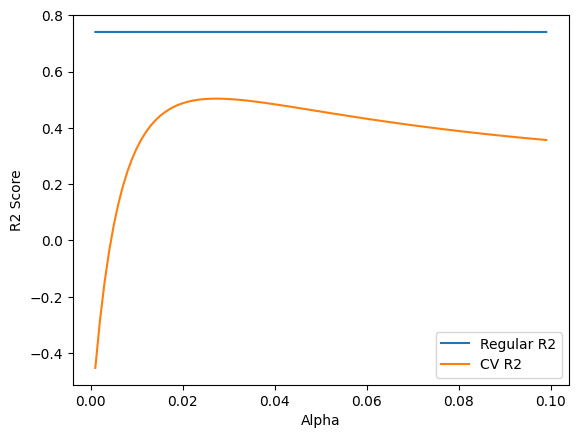

alpha1: 0.042, R2 Score: 0.7407177111403742, CV R2 Score: 0.4786640492489889
alpha2: 0.027, R2 Score: 0.7407013550635286, CV R2 Score: 0.5037055325847374


In [136]:
prettyPrintReg(graphRegressionValues(ridgeRegression, scaled_data_array, 1, 100, 1, 1000))

In [137]:
ridge_main = ridgeRegression(0.027, **scaled_data_array)["Model"]


In [138]:
prettyPrint(ridgeRegression(0.027, **scaled_data_array))

            Model: 		Ridge(alpha=0.027)
            R2 Score: 		0.7407013550635286
            CV R2 Score: 	0.5037055325847374
            MAE: 		326.90490921035286
            RMSE: 		425.7140022718935


/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.945e+05, tolerance: 2.063e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.472e+06, tolerance: 2.509e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: O

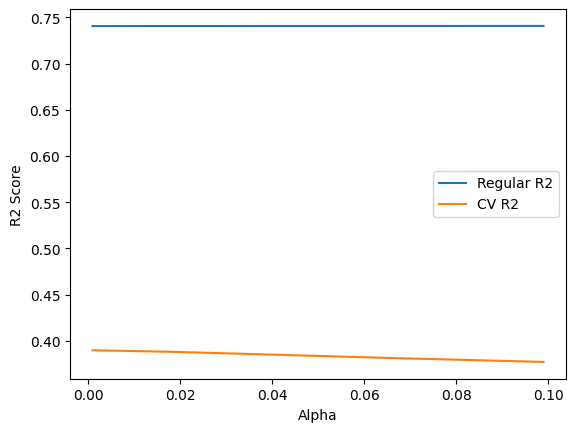

alpha1: 0.099, R2 Score: 0.7407390802818031, CV R2 Score: 0.37720597426884417
alpha2: 0.001, R2 Score: 0.7405787544873326, CV R2 Score: 0.3898195048380956


In [139]:
prettyPrintReg(graphRegressionValues(lassoRegression, scaled_data_array, 1, 100, 1, 1000))


## Remove Overfitting

Both point towards overfitting.
Now I will attempt to remove some columns

In [140]:
scaled_data.dtypes

TotalSteps                  float64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes           float64
FairlyActiveMinutes         float64
LightlyActiveMinutes        float64
SedentaryMinutes            float64
Calories                      int64
dtype: object

In [141]:
scaled_data.describe()

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,4.570000e+02,4.570000e+02,4.570000e+02,457.000000,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,457.000000,457.000000
mean,-6.219192e-17,1.554798e-17,-7.773991e-17,0.000000,1.243838e-16,3.886995e-17,-3.109596e-17,4.664394e-17,7.773991e-17,-2.137847e-17,-1.943498e-18,0.000000,2189.452954
std,1.001096e+00,1.001096e+00,1.001096e+00,1.001096,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096,815.484523
min,-1.213994e+00,-1.143692e+00,-1.134289e+00,-0.211514,-4.753180e-01,-5.766193e-01,-1.293110e+00,-2.245612e-01,-5.754502e-01,-3.613598e-01,-1.393199e+00,-2.861355,0.000000
25%,-8.453392e-01,-7.979007e-01,-8.193347e-01,-0.211514,-4.753180e-01,-5.766193e-01,-9.038613e-01,-2.245612e-01,-5.754502e-01,-3.613598e-01,-8.689165e-01,-0.793941,1776.000000
50%,-1.039506e-01,-1.406519e-01,-1.279123e-01,-0.211514,-4.753180e-01,-5.525254e-01,1.780842e-02,-2.245612e-01,-5.754502e-01,-3.337118e-01,8.953744e-02,0.183328,2062.000000
75%,6.771221e-01,6.122412e-01,6.151822e-01,-0.211514,5.196463e-02,2.305265e-01,7.023495e-01,-2.245612e-01,2.899597e-01,8.100800e-02,7.121229e-01,0.860584,2667.000000
max,4.070486e+00,5.607823e+00,5.639682e+00,7.718511,8.347610e+00,7.133430e+00,4.304020e+00,1.157135e+01,6.417062e+00,1.788631e+01,4.504979e+00,1.320999,4562.000000


TotalSteps                 -2355.119445
VeryActiveDistance         -1451.198970
LightActiveDistance         -541.699762
ModeratelyActiveDistance    -279.642450
LoggedActivitiesDistance    -101.451328
SedentaryActiveDistance       -2.075316
TrackerDistance                7.219253
SedentaryMinutes             220.749508
FairlyActiveMinutes          223.504171
LightlyActiveMinutes         245.286655
VeryActiveMinutes            783.605307
TotalDistance               3843.212379
dtype: float64


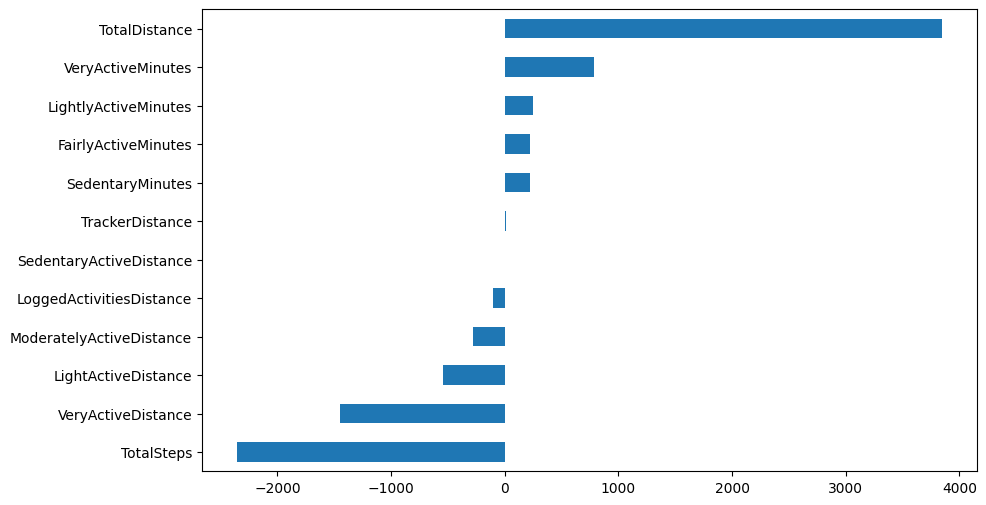

In [142]:
coefs = pd.Series(ridge_main.coef_, index=scaled_data_array["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## We observe that the coefficients for `SedentaryActiveDistance` is extremely small, hence that can be removed.
We can also remove `LoggedActivitiesDistance`

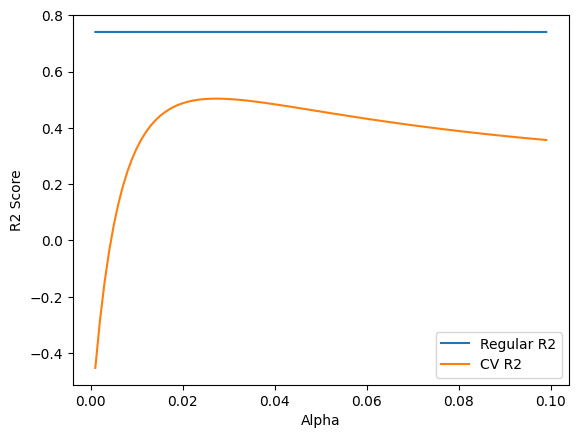

alpha1: 0.042, R2 Score: 0.7407177111403742, CV R2 Score: 0.4786640492489889
alpha2: 0.027, R2 Score: 0.7407013550635286, CV R2 Score: 0.5037055325847374


In [143]:
values = graphRegressionValues(ridgeRegression, scaled_data_array, 1, 100, 1, 1000)
alpha1 = values["alpha2"]
prettyPrintReg(values)


### Both Removed

In [144]:
data_filtered = getData(data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance"])
filtered_data_array = splitData(data=data_filtered, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


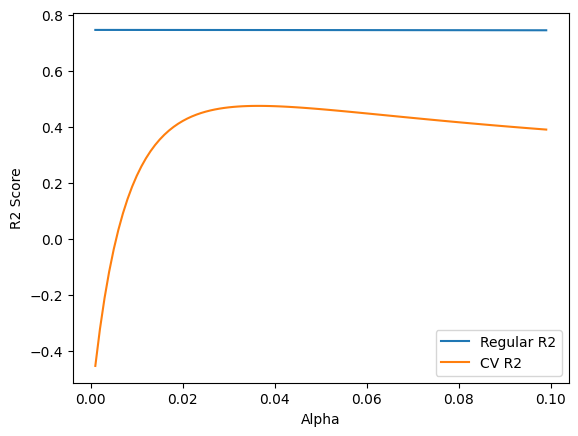

alpha1: 0.001, R2 Score: 0.7458279516997491, CV R2 Score: -0.45411944109836283
alpha2: 0.036, R2 Score: 0.7454644260260965, CV R2 Score: 0.474527834708694


In [145]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array, 1, 100, 1, 1000))

### Only Logged Removed

In [146]:
data_filtered = getData(data, scaled=True, dropped_cols=["LoggedActivitiesDistance"])
filtered_data_array = splitData(data=data_filtered, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


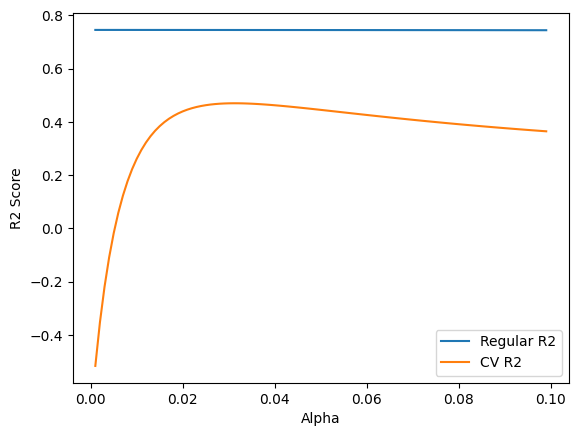

alpha1: 0.001, R2 Score: 0.7450380492323414, CV R2 Score: -0.5163925280332059
alpha2: 0.031, R2 Score: 0.7447834098514, CV R2 Score: 0.4696863724372048


In [147]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array, 1, 100, 1, 1000))

### Only Sedentary Removed

In [148]:
data_filtered_1 = getData(data, scaled=True, dropped_cols=["SedentaryActiveDistance"])
filtered_data_array_1 = splitData(data=data_filtered_1, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


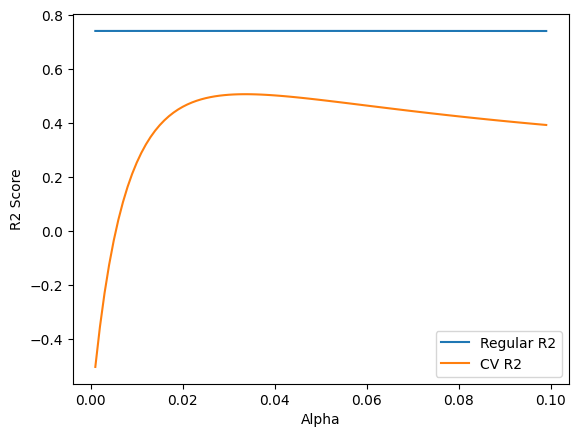

alpha1: 0.035, R2 Score: 0.7410765410310283, CV R2 Score: 0.5064691002855362
alpha2: 0.034, R2 Score: 0.7410764005944699, CV R2 Score: 0.5067019991285944


In [149]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_1, 1, 100, 1, 1000))

In [150]:
ridge_filtered_1 = ridgeRegression(0.034, **filtered_data_array_1)["Model"]

TotalSteps                 -2344.041914
VeryActiveDistance         -1445.732205
LightActiveDistance         -538.853202
ModeratelyActiveDistance    -278.704145
LoggedActivitiesDistance    -100.202971
TrackerDistance               19.217730
SedentaryMinutes             220.623232
FairlyActiveMinutes          223.225758
LightlyActiveMinutes         244.459415
VeryActiveMinutes            781.571476
TotalDistance               3814.922578
dtype: float64


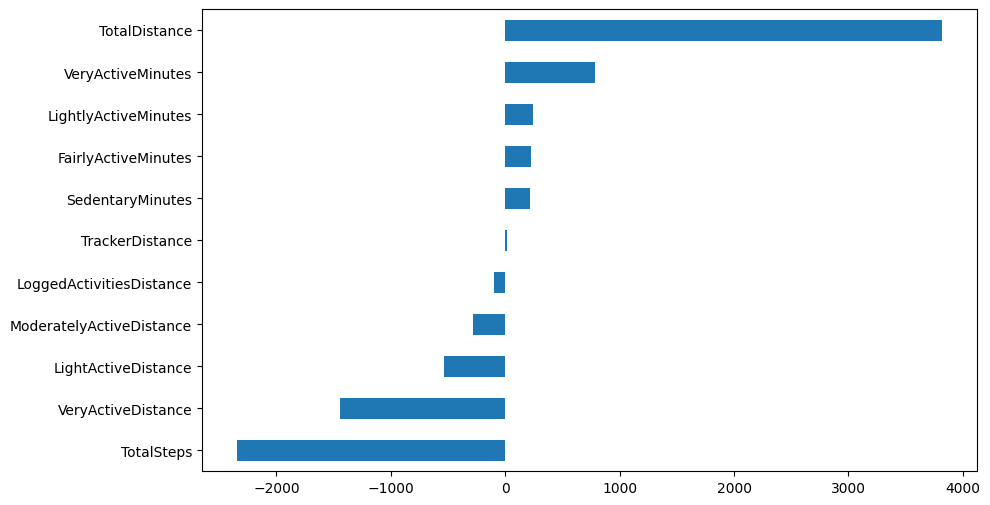

In [151]:
coefs = pd.Series(ridge_filtered_1.coef_, index=filtered_data_array_1["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

Let us see what is the difference between `TotalDistance` and `TrackerDistance`

In [152]:
(data.TotalDistance - data.TrackerDistance).sort_values()

215   -0.57
289    0.00
302    0.00
301    0.00
300    0.00
       ... 
361    1.36
142    1.61
335    2.03
139    3.22
338    6.73
Length: 457, dtype: float64

In [153]:
(data.TotalDistance - data.TrackerDistance).describe()

count    457.000000
mean       0.053676
std        0.402765
min       -0.570000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.730000
dtype: float64

In [154]:
len(main_data.Id[data.TotalDistance - data.TrackerDistance != 0])

16

In [155]:
(data.Calories[data.TotalDistance - data.TrackerDistance != 0])

139    2881
142    1144
215    2259
335    2224
338    2442
359    2170
360    2244
361    2188
364    2188
366    2573
369    2886
370    2676
371    2811
372    2840
373    2871
377    1023
Name: Calories, dtype: int64

In [156]:
(data.TrackerDistance[data.TotalDistance - data.TrackerDistance != 0]) - (data.TotalDistance[data.TotalDistance - data.TrackerDistance != 0])

139   -3.22
142   -1.61
215    0.57
335   -2.03
338   -6.73
359   -0.61
360   -0.78
361   -1.36
364   -0.92
366   -1.25
369   -1.19
370   -1.06
371   -1.18
372   -1.15
373   -1.20
377   -0.81
dtype: float64

In [157]:
len(data)

457

Since 16/457 is a very small ratio, and the difference is small mostly we will drop this column.

## Dropping TotalDistance

In [158]:
data_filtered_2 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance","TotalDistance"])
filtered_data_array_2 = splitData(data=data_filtered_2, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


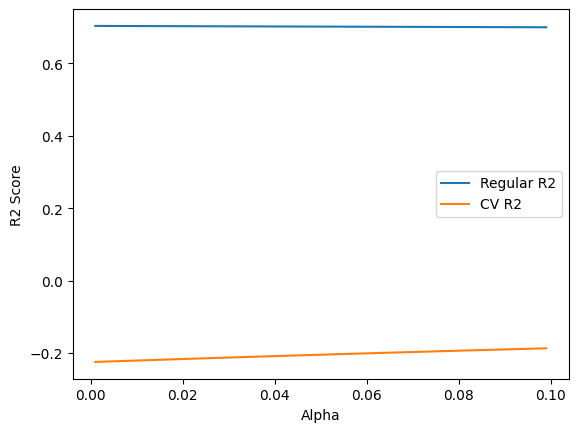

alpha1: 0.001, R2 Score: 0.7034491287192832, CV R2 Score: -0.22480277627143316
alpha2: 0.099, R2 Score: 0.6997306977489304, CV R2 Score: -0.18720319497602392


In [159]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_2, 1, 100, 1, 1000))

## Dropping TrackerDistance

In [161]:
data_filtered_2 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])
filtered_data_array_2 = splitData(data=data_filtered_2, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


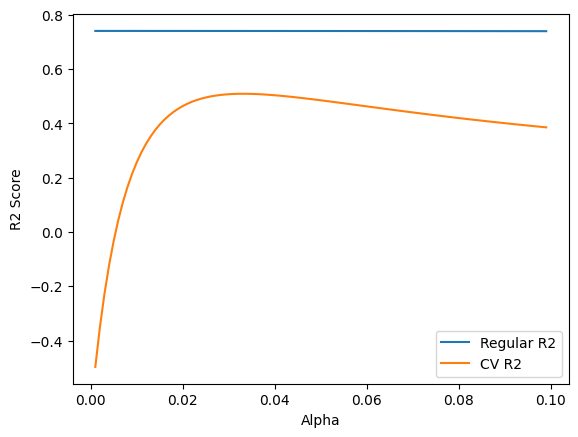

alpha1: 0.001, R2 Score: 0.7411737149754727, CV R2 Score: -0.49711491735175173
alpha2: 0.033, R2 Score: 0.7410072376045951, CV R2 Score: 0.5095490981155818


In [162]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_2, 1, 100, 1, 1000))

In [163]:
ridge_filtered_2 = ridgeRegression(0.033, **filtered_data_array_2)["Model"]
prettyPrint(ridgeRegression(0.033, **filtered_data_array_2))

            Model: 		Ridge(alpha=0.033)
            R2 Score: 		0.7410072376045951
            CV R2 Score: 	0.5095490981155818
            MAE: 		326.5937404659086
            RMSE: 		425.4628306804407


TotalSteps                 -2345.241372
VeryActiveDistance         -1446.481797
LightActiveDistance         -538.742807
ModeratelyActiveDistance    -278.924828
LoggedActivitiesDistance    -101.793497
SedentaryMinutes             220.518850
FairlyActiveMinutes          223.649554
LightlyActiveMinutes         243.974816
VeryActiveMinutes            782.264062
TotalDistance               3835.846780
dtype: float64


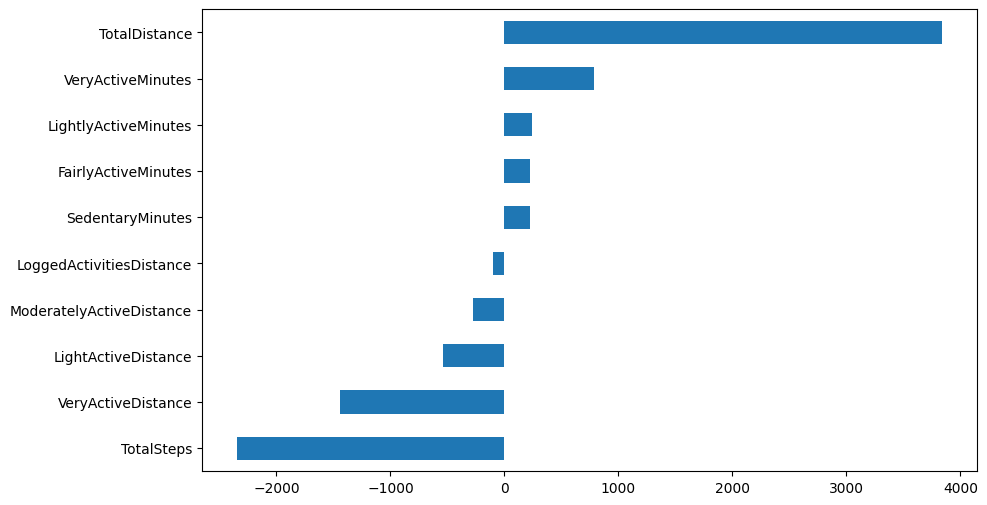

In [164]:
coefs = pd.Series(ridge_filtered_2.coef_, index=filtered_data_array_2["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## Dropping SedenteryMinutes

In [231]:
data_filtered_2_1 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "SedentaryMinutes"])
filtered_data_array_2_1 = splitData(data=data_filtered_2_1, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


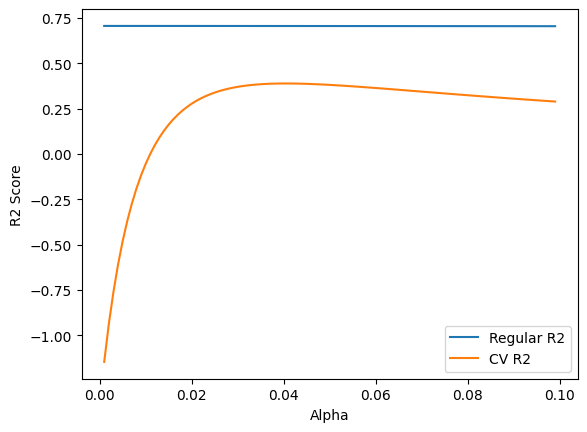

alpha1: 0.001, R2 Score: 0.70694195882123, CV R2 Score: -1.1472089835291945
alpha2: 0.04, R2 Score: 0.7064943587656685, CV R2 Score: 0.3893194389864506


In [232]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_2_1, 1, 100, 1, 1000))

In [230]:
ridge_filtered_2_1 = ridgeRegression(0.04, **filtered_data_array_2_1)["Model"]
prettyPrint(ridgeRegression(0.04, **filtered_data_array_2_1))

            Model: 		Ridge(alpha=0.04)
            R2 Score: 		0.7064943587656685
            CV R2 Score: 	0.3893194389864506
            MAE: 		351.81230974514256
            RMSE: 		452.92473379791824


TotalSteps                 -2345.241372
VeryActiveDistance         -1446.481797
LightActiveDistance         -538.742807
ModeratelyActiveDistance    -278.924828
LoggedActivitiesDistance    -101.793497
SedentaryMinutes             220.518850
FairlyActiveMinutes          223.649554
LightlyActiveMinutes         243.974816
VeryActiveMinutes            782.264062
TotalDistance               3835.846780
dtype: float64


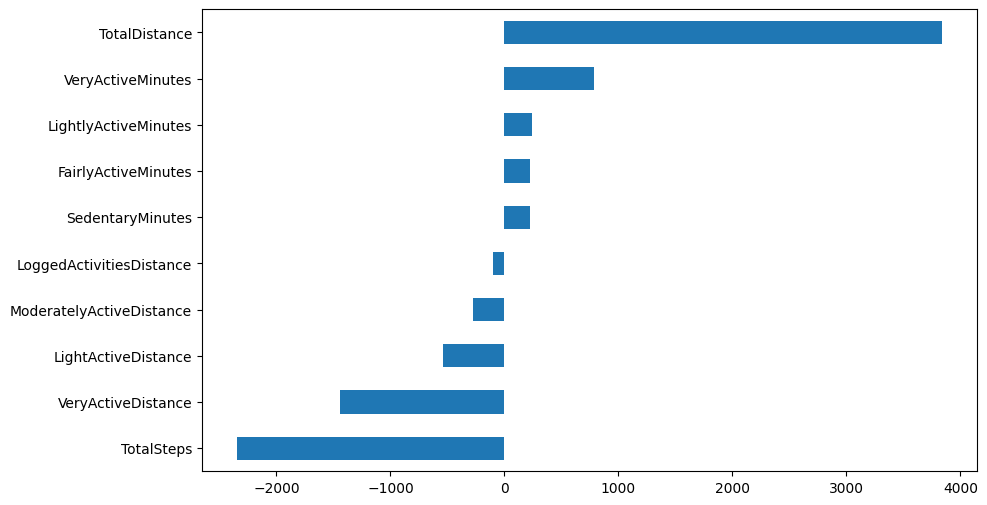

In [168]:
coefs = pd.Series(ridge_filtered_2.coef_, index=filtered_data_array_2["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

In [169]:
(main_data.TotalDistance / main_data.TotalSteps).describe()


count    396.000000
mean       0.000701
std        0.000097
min        0.000000
25%        0.000661
50%        0.000683
75%        0.000739
max        0.001429
dtype: float64

In [170]:
test_df = main_data[main_data.TotalSteps == 0]
test_df.Calories.describe()

count      61.000000
mean     1575.032787
std       728.352043
min         0.000000
25%      1347.000000
50%      1776.000000
75%      1878.000000
max      4562.000000
Name: Calories, dtype: float64

In [171]:
test_df.SedentaryMinutes.describe()

count      61.000000
mean     1339.557377
std       291.848564
min       198.000000
25%      1440.000000
50%      1440.000000
75%      1440.000000
max      1440.000000
Name: SedentaryMinutes, dtype: float64

In [172]:
print(*test_df.SedentaryMinutes.sort_values())

198 425 426 494 669 780 994 1407 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440 1440


## Dropping TotalSteps

### Dropping Both "TotalDistance", "TotalSteps"

In [173]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "TotalDistance", "TotalSteps"])

data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


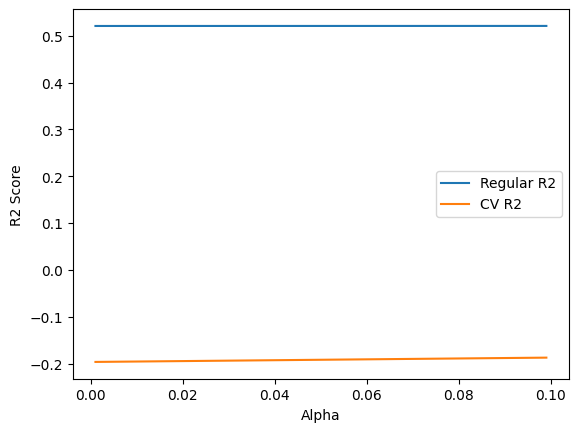

alpha1: 0.099, R2 Score: 0.5208964883951783, CV R2 Score: -0.18712973581346187
alpha2: 0.099, R2 Score: 0.5208964883951783, CV R2 Score: -0.18712973581346187


In [174]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

### Dropping "TotalSteps"

In [175]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "TotalSteps"])

data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


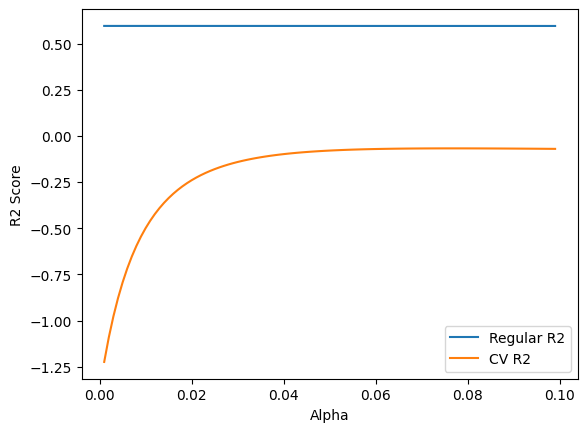

alpha1: 0.001, R2 Score: 0.5953797152918339, CV R2 Score: -1.2236910359802167
alpha2: 0.077, R2 Score: 0.5952115383012653, CV R2 Score: -0.06755631694141273


In [176]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

### Dropping "TotalDistance"

In [177]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "TotalSteps"])

data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


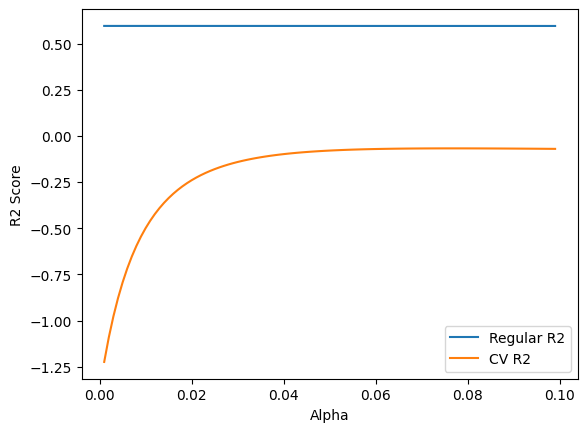

alpha1: 0.001, R2 Score: 0.5953797152918339, CV R2 Score: -1.2236910359802167
alpha2: 0.077, R2 Score: 0.5952115383012653, CV R2 Score: -0.06755631694141273


In [178]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

### Dropping None

In [233]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])

data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


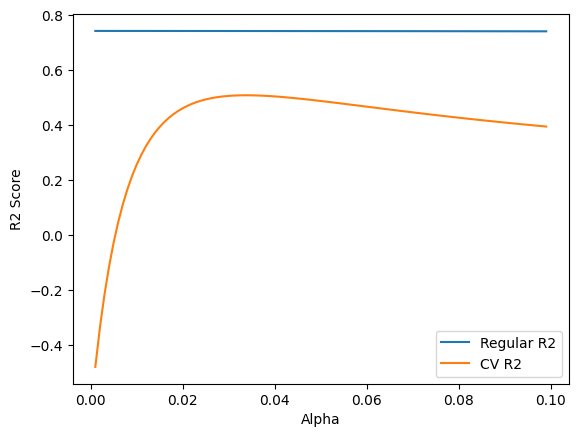

alpha1: 0.001, R2 Score: 0.7424096000976388, CV R2 Score: -0.4797763904110903
alpha2: 0.034, R2 Score: 0.7420536718876126, CV R2 Score: 0.5083514615465516


In [234]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

In [236]:
ridge_filtered_3 = ridgeRegression(0.034, **filtered_data_array_3)["Model"]
prettyPrint(ridgeRegression(0.034, **filtered_data_array_3))

            Model: 		Ridge(alpha=0.034)
            R2 Score: 		0.7420536718876126
            CV R2 Score: 	0.5083514615465516
            MAE: 		329.58072626296865
            RMSE: 		424.6024407713967


TotalSteps                 -2257.131957
VeryActiveDistance         -1386.740130
LightActiveDistance         -504.069309
ModeratelyActiveDistance    -269.337583
LoggedActivitiesDistance    -101.080883
StepSize                      81.489416
LightlyActiveMinutes         217.040331
FairlyActiveMinutes          230.535474
SedentaryMinutes             237.651999
VeryActiveMinutes            769.586209
TotalDistance               3655.430870
dtype: float64


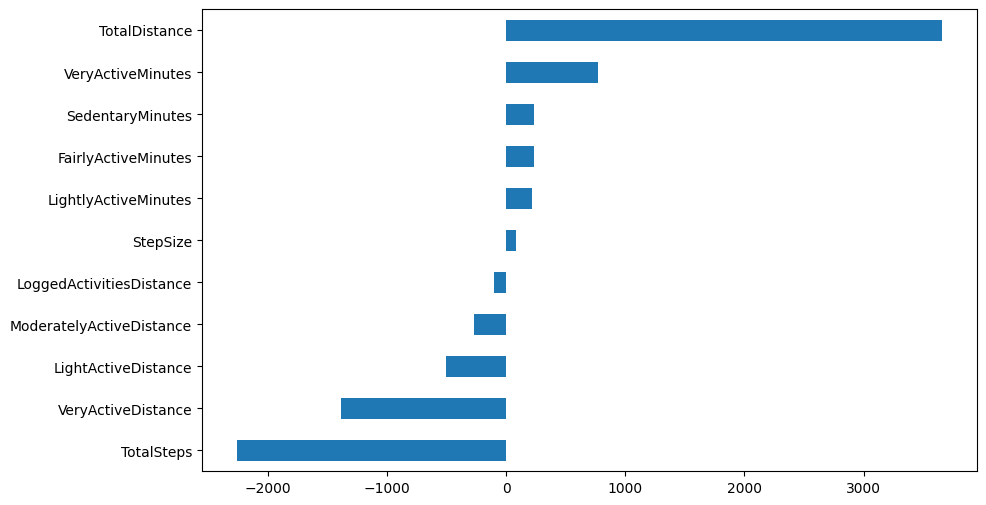

In [182]:
coefs = pd.Series(ridge_filtered_3.coef_, index=filtered_data_array_3["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## Working with "VeryActiveMinutes", "FairlyActiveMinutes", "VeryActiveDistance" and "ModeratelyActiveDistance"

### Dropping "VeryActiveMinutes", "FairlyActiveMinutes"

In [186]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "FairlyActiveMinutes", "VeryActiveMinutes"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 9)
Test shape: (138, 9)


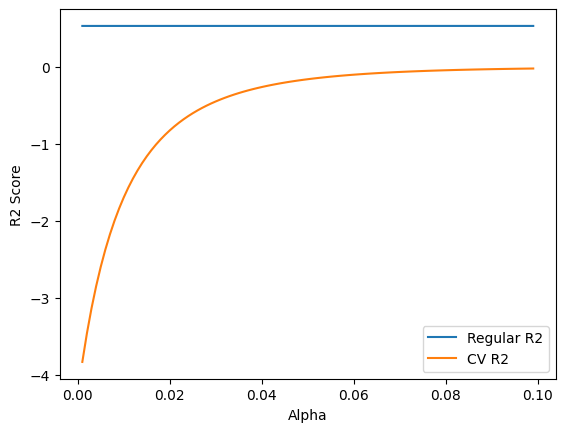

alpha1: 0.088, R2 Score: 0.5272927996249862, CV R2 Score: -0.03620730238581822
alpha2: 0.099, R2 Score: 0.527290026284731, CV R2 Score: -0.025375246141888352


In [187]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "VeryActiveMinutes", "ModeratelyActiveDistance"

In [188]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveMinutes"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 9)
Test shape: (138, 9)


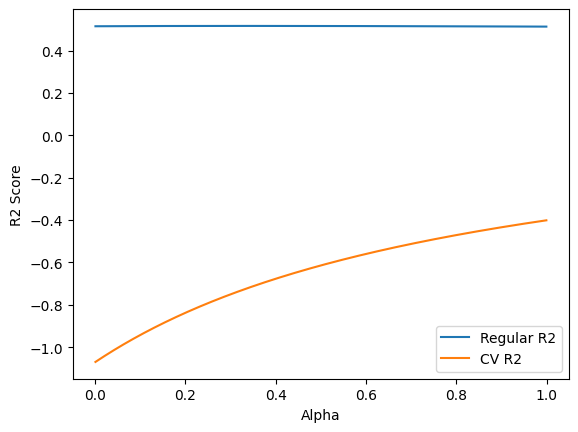

alpha1: 0.324, R2 Score: 0.5169674233597399, CV R2 Score: -0.7317584737398175
alpha2: 0.999, R2 Score: 0.5137065267572742, CV R2 Score: -0.40099433512178456


In [189]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 1000, 1, 1000))

### Dropping "VeryActiveDistance", "ModeratelyActiveDistance"

In [190]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 9)
Test shape: (138, 9)


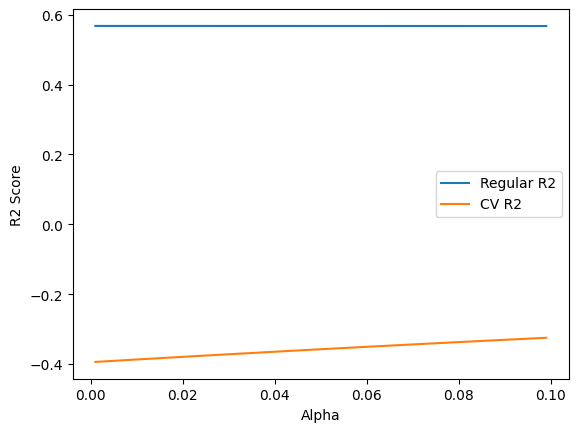

alpha1: 0.001, R2 Score: 0.5680724817889022, CV R2 Score: -0.39407539441187067
alpha2: 0.099, R2 Score: 0.5677755210464248, CV R2 Score: -0.3249569327773515


In [191]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "VeryActiveDistance", "FairlyActiveMinutes"

In [192]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "FairlyActiveMinutes", "VeryActiveDistance"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 9)
Test shape: (138, 9)


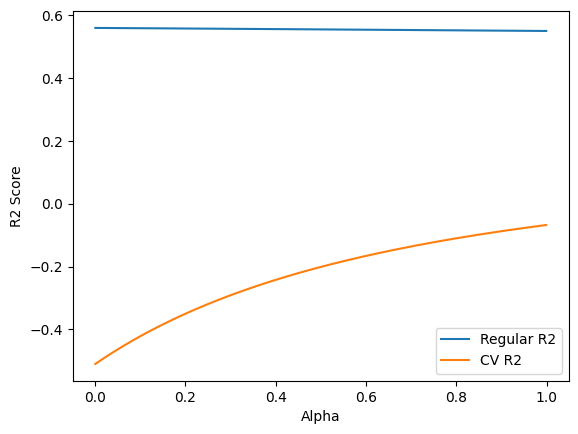

alpha1: 0.001, R2 Score: 0.5600080368887532, CV R2 Score: -0.5101413020530052
alpha2: 0.999, R2 Score: 0.5503292784081811, CV R2 Score: -0.06768741505252826


In [193]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 1000, 1, 1000))

## 61 abnormal rows

In [198]:
data[data.TotalSteps == 0].describe()

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,61.0,61.0,61.0,61.000000,61.0,61.0,61.0,61.0,61.000000,61.000000,61.0,61.000000,61.000000
mean,0.0,0.0,0.0,0.079148,0.0,0.0,0.0,0.0,0.868852,10.819672,0.0,1339.557377,1575.032787
std,0.0,0.0,0.0,0.618166,0.0,0.0,0.0,0.0,4.903996,84.504341,0.0,291.848564,728.352043
min,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,198.000000,0.000000
25%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1440.000000,1347.000000
50%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1440.000000,1776.000000
75%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1440.000000,1878.000000
max,0.0,0.0,0.0,4.828032,0.0,0.0,0.0,0.0,33.000000,660.000000,0.0,1440.000000,4562.000000


In [199]:
data

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,11004,7.110000,7.110000,0.0,2.57,0.46,4.07,0.00,33,12,205,804,1819
1,17609,11.550000,11.550000,0.0,6.92,0.73,3.91,0.00,89,17,274,588,2154
2,12736,8.530000,8.530000,0.0,4.66,0.16,3.71,0.00,56,5,268,605,1944
3,13231,8.930000,8.930000,0.0,3.19,0.79,4.95,0.00,39,20,224,1080,1932
4,12041,7.850000,7.850000,0.0,2.16,1.09,4.61,0.00,28,28,243,763,1886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,23014,20.389999,20.389999,0.0,11.10,0.63,8.62,0.00,70,29,359,982,4196
453,16470,8.070000,8.070000,0.0,0.00,0.02,8.02,0.00,90,9,289,1052,3841
454,28497,27.530001,27.530001,0.0,21.92,1.12,4.46,0.00,128,46,211,1055,4526
455,10622,8.060000,8.060000,0.0,1.47,0.15,6.37,0.01,18,7,225,1190,2820


## Dropping 0 rows

In [200]:
activity_cols = data.drop(columns=["Calories", "SedentaryMinutes"]).columns
data_cleaned = data[~(data[activity_cols] == 0).all(axis=1)]

In [201]:
data_filtered_3 = getData(scaled=True, data=data_cleaned, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])
filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (279, 11)
Test shape: (120, 11)


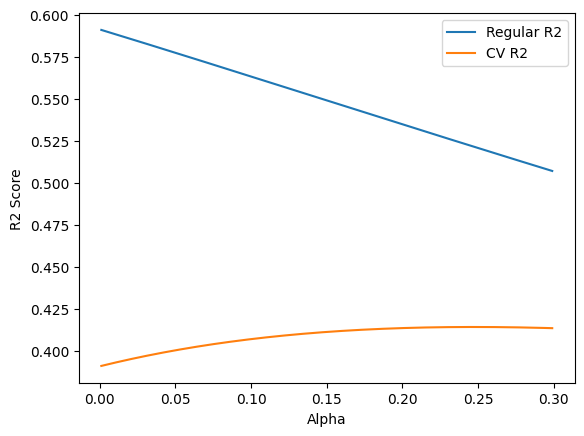

alpha1: 0.001, R2 Score: 0.5909133854373274, CV R2 Score: 0.39104295607760775
alpha2: 0.247, R2 Score: 0.5215006154430121, CV R2 Score: 0.41420089972416674


In [202]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 300, 1, 1000))

# 2. BinaryTreeRegressor

## Main Regressor

In [213]:
def randomForestRegressor(regressor, X, y, X_train, y_train, X_test, y_test, kwargs={"n_estimators": 1000, "max_depth": 10, "random_state": 42}):
    forest = regressor(**kwargs)
    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_test)

    cv_scores_full = cross_val_score(forest, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    return {
        "Model": forest,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [214]:
scaled_data = getData(data=data, scaled=True, dropped_cols=[])
scaled_data_array = splitData(randomState=randomState, data=scaled_data)
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, kwargs={"n_estimators": 100, "max_depth": 100, "random_state": randomState}, **scaled_data_array))

Train shape: (319, 13)
Test shape: (138, 13)
            Model: 		RandomForestRegressor(max_depth=100, random_state=42)
            R2 Score: 		0.6623897220872248
            CV R2 Score: 	0.38893840952842
            MAE: 		374.75998600329984
            RMSE: 		485.76435227829734


## Graph Comparison

In [239]:
def prettyPrintRegRF(array):
    print(f'num_estimators1: {array["estimators1"]}, max_depth1: {array["depth1"]}, R2 Score: {array["R2 Score1"]}, CV R2 Score: {array["CV R2 Score1"]}')
    print(f'num_estimators2: {array["estimators2"]}, max_depth2: {array["depth2"]}, R2 Score: {array["R2 Score2"]}, CV R2 Score: {array["CV R2 Score2"]}')

In [ ]:
def graphRFRegressionValuesE(data_array, sequence):
    estimators = []
    r2_scores = []
    cv_r2_scores = []
    maxr2i = 0
    maxcvr2i = 0
    for i in sequence:
        alpha = i
        estimators.append(alpha)
        _, R2, cvR2, _, _, _  = randomForestRegressor(*data_array, nEstimators=alpha, maxDepth=10, randomState=randomState)
        r2_scores.append(R2)
        cv_r2_scores.append(cvR2)
        if(R2 > r2_scores[maxr2i]):
            maxr2i = i - 1
        if(cvR2 > cv_r2_scores[maxcvr2i]):
            maxcvr2i = i - 1

    plt.plot(estimators, r2_scores, label="Regular R2")
    plt.plot(estimators, cv_r2_scores, label="CV R2")
    plt.legend()
    plt.xlabel("Estimators")
    plt.ylabel("R2 Score")
    plt.show()
    return [estimators[maxr2i], r2_scores[maxr2i], cv_r2_scores[maxr2i], estimators[maxcvr2i], r2_scores[maxcvr2i], cv_r2_scores[maxcvr2i]]

In [ ]:
def graphRFRegressionValuesD(data_array, sequence):
    depths = []
    r2_scores = []
    cv_r2_scores = []
    maxr2i = 0
    maxcvr2i = 0
    for i in sequence:
        alpha = i
        depths.append(alpha)
        _, R2, cvR2, _, _, _  = randomForestRegressor(*data_array, nEstimators=10, maxDepth=i, randomState=randomState)
        r2_scores.append(R2)
        cv_r2_scores.append(cvR2)
        if(R2 > r2_scores[maxr2i]):
            maxr2i = i - 1
        if(cvR2 > cv_r2_scores[maxcvr2i]):
            maxcvr2i = i - 1

    plt.plot(depths, r2_scores, label="Regular R2")
    plt.plot(depths, cv_r2_scores, label="CV R2")
    plt.legend()
    plt.xlabel("Depth")
    plt.ylabel("R2 Score")
    plt.show()
    return [depths[maxr2i], r2_scores[maxr2i], cv_r2_scores[maxr2i], depths[maxcvr2i], r2_scores[maxcvr2i], cv_r2_scores[maxcvr2i]]

In [249]:
def graphRFRegressionValuesC(data_array, estimatorSequence, maxDepthSequence):
    maxR2, maxR2CV, maxDepth, maxEstimators = 0, 0, 0, 0
    maxCVR2, maxCVR2CV, maxCVDepth, maxCVEstimators = 0, 0, 0, 0
    for estimator in estimatorSequence:
        for depth in maxDepthSequence:
            retVal  = randomForestRegressor(regressor=RandomForestRegressor, **data_array, kwargs={"n_estimators":estimator, "max_depth":depth, "random_state":randomState})
            R2 = retVal["R2 Score"]
            cvR2 = retVal["CV R2 Score"]
            if(R2 > maxR2):
                maxR2 = R2
                maxR2CV = cvR2
                maxDepth = depth
                maxEstimators = estimator
            if(cvR2 > maxCVR2CV):
                maxCVR2 = R2
                maxCVR2CV = cvR2
                maxCVDepth = depth
                maxCVEstimators = estimator

    return {
        "estimators1": maxEstimators,
        "depth1": maxDepth,
        "R2 Score1": maxR2,
        "CV R2 Score 1": maxR2CV,
        "estimators2": maxCVEstimators,
        "depth2": maxCVDepth,
        "R2 Score 2": maxCVR2,
        "CV R2 Score 2": maxCVR2CV
    }

In [250]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=scaled_data_array, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

KeyError: 'CV R2 Score1'

## Feature Engineering

In [ ]:
main_forest, _, _, _, _, _  = randomForestRegressor(*scaled_data_array, nEstimators=16, maxDepth=19, randomState=randomState)

In [ ]:
importances = main_forest.feature_importances_
feature_names = scaled_data_array[0].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
1,TotalDistance,0.291311
8,VeryActiveMinutes,0.195711
11,SedentaryMinutes,0.155177
10,LightlyActiveMinutes,0.085049
6,LightActiveDistance,0.079428
2,TrackerDistance,0.062916
0,TotalSteps,0.043348
9,FairlyActiveMinutes,0.038953
4,VeryActiveDistance,0.022753
5,ModeratelyActiveDistance,0.018181


### Remove `SedentaryActiveDistance` and `LoggedActivitiesDistance`

In [ ]:
filtered_data_regressor_1 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance"])
filtered_data_array_regressor_1 = splitData(randomState=randomState, data=filtered_data_regressor_1)

Train shape: (273, 11)
CV shape: (92, 11)
Test shape: (92, 11)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_1, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 31)))

num_estimators1: 14, max_depth1: 14, R2 Score: 0.6968851971738176, CV R2 Score: 0.5641377725327773
num_estimators2: 18, max_depth2: 10, R2 Score: 0.6730357971611121, CV R2 Score: 0.5793735576908888


In [ ]:
prettyPrint(randomForestRegressor(*filtered_data_array_regressor_1, nEstimators=16, maxDepth=20, randomState=randomState))

Model: 				RandomForestRegressor(max_depth=20, n_estimators=16, random_state=42)
R2 Score: 			0.6704466554178709
CV R2 Score(Full Data): 	0.564421598973144
CV R2 Score(CV Data): 		-0.043800829351710126
MSE: 				0.4373213066681001
RMSE: 				0.5625428240925524


In [ ]:
filtered_forest_1 = randomForestRegressor(*filtered_data_array_regressor_1, nEstimators=16, maxDepth=20, randomState=randomState)[0]

In [ ]:
importances = filtered_forest_1.feature_importances_
feature_names = filtered_data_array_regressor_1[0].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
1,TotalDistance,0.299128
6,VeryActiveMinutes,0.195898
9,SedentaryMinutes,0.153921
8,LightlyActiveMinutes,0.097141
5,LightActiveDistance,0.073673
2,TrackerDistance,0.053675
0,TotalSteps,0.046354
7,FairlyActiveMinutes,0.040176
3,VeryActiveDistance,0.021608
4,ModeratelyActiveDistance,0.018427


In [ ]:
filtered_data_regressor_1.dtypes

TotalSteps                  float64
TotalDistance               float64
TrackerDistance             float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
VeryActiveMinutes           float64
FairlyActiveMinutes         float64
LightlyActiveMinutes        float64
SedentaryMinutes            float64
Calories                    float64
dtype: object

### Remove `TotalDistance`

In [ ]:
filtered_data_regressor_2 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TotalDistance"])
filtered_data_array_regressor_2 = splitData(randomState=randomState, data=filtered_data_regressor_2)

Train shape: (273, 10)
CV shape: (92, 10)
Test shape: (92, 10)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_2, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 14, max_depth1: 16, R2 Score: 0.6831757880168478, CV R2 Score: 0.5465302016110462
num_estimators2: 13, max_depth2: 10, R2 Score: 0.6558691458200683, CV R2 Score: 0.558394382973083


### Remove `TrackerDistance`

In [ ]:
filtered_data_regressor_2 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance"])
filtered_data_array_regressor_2 = splitData(randomState=randomState, data=filtered_data_regressor_2)

Train shape: (273, 10)
CV shape: (92, 10)
Test shape: (92, 10)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_2, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 14, max_depth1: 13, R2 Score: 0.7039980798786345, CV R2 Score: 0.5729489037014958
num_estimators2: 13, max_depth2: 12, R2 Score: 0.673545057373337, CV R2 Score: 0.5770530940456242


### Remove `VeryActiveDistance` and `ModeratelyActiveDistance`

In [ ]:
filtered_data_regressor_3 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])
filtered_data_array_regressor_3 = splitData(randomState=randomState, data=filtered_data_regressor_3)

Train shape: (273, 8)
CV shape: (92, 8)
Test shape: (92, 8)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_3, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 11, max_depth1: 8, R2 Score: 0.6728075769952485, CV R2 Score: 0.5754659796755851
num_estimators2: 13, max_depth2: 8, R2 Score: 0.6643222340029602, CV R2 Score: 0.5803686246733842


In [ ]:
filtered_forest_3 = randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=16, maxDepth=12, randomState=randomState)[0]

In [ ]:
importances = filtered_forest_3.feature_importances_
feature_names = filtered_data_array_regressor_3[0].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
1,TotalDistance,0.334460
3,VeryActiveMinutes,0.211318
6,SedentaryMinutes,0.171022
5,LightlyActiveMinutes,0.090927
2,LightActiveDistance,0.079404
0,TotalSteps,0.064782
4,FairlyActiveMinutes,0.048086


### Remove `SedenteryMinutes`

In [ ]:
filtered_data_regressor_4 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "SedentaryMinutes"])
filtered_data_array_regressor_4 = splitData(randomState=randomState, data=filtered_data_regressor_4)

Train shape: (273, 7)
CV shape: (92, 7)
Test shape: (92, 7)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_4, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 14, max_depth1: 10, R2 Score: 0.6125697480743084, CV R2 Score: 0.4231564566646913
num_estimators2: 13, max_depth2: 8, R2 Score: 0.5999474605468706, CV R2 Score: 0.4510853612857549


In [ ]:
filtered_forest_4 = randomForestRegressor(*filtered_data_array_regressor_4, nEstimators=16, maxDepth=12, randomState=randomState)[0]

In [ ]:
importances = filtered_forest_4.feature_importances_
feature_names = filtered_data_array_regressor_3[0].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

ValueError: All arrays must be of the same length

In [ ]:
importances = filtered_forest_3.feature_importances_
feature_names = filtered_data_array_regressor_3[0].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
1,TotalDistance,0.334460
3,VeryActiveMinutes,0.211318
6,SedentaryMinutes,0.171022
5,LightlyActiveMinutes,0.090927
2,LightActiveDistance,0.079404
0,TotalSteps,0.064782
4,FairlyActiveMinutes,0.048086


### Remove `0 rows`

In [ ]:
activity_cols = data.drop(columns=["Calories", "SedentaryMinutes"]).columns
data_cleaned = data[~(data[activity_cols] == 0).all(axis=1)]

In [ ]:
filtered_data_regressor_2 = getData(data=data_cleaned, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])
filtered_data_array_regressor_2 = splitData(randomState=randomState, data=filtered_data_regressor_2)

Train shape: (239, 8)
CV shape: (80, 8)
Test shape: (80, 8)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_2, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 10, max_depth1: 19, R2 Score: 0.4754945214745635, CV R2 Score: 0.3051517001982426
num_estimators2: 20, max_depth2: 11, R2 Score: 0.43818316326264684, CV R2 Score: 0.3300703080139929


In [ ]:
filtered_forest_2 = randomForestRegressor(*filtered_data_array_regressor_2, nEstimators=16, maxDepth=17, randomState=randomState)[0]

In [ ]:
importances = filtered_forest_2.feature_importances_
feature_names = filtered_data_array_regressor_2[0].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
1,TotalDistance,0.332243
5,VeryActiveMinutes,0.198509
8,SedentaryMinutes,0.157130
7,LightlyActiveMinutes,0.091951
4,LightActiveDistance,0.085202
0,TotalSteps,0.055118
6,FairlyActiveMinutes,0.039571
2,VeryActiveDistance,0.022691
3,ModeratelyActiveDistance,0.017584


### Remove `TotalSteps`

#### Not Active

In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_3 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "TotalDistance"])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_3 = splitData(randomState=randomState, data=filtered_data_regressor_3)

Train shape: (273, 8)
CV shape: (92, 8)
Test shape: (92, 8)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_3, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 10, max_depth1: 10, R2 Score: 0.8112452282759642, CV R2 Score: 0.4502887148536738
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6964036897347565, CV R2 Score: 0.5250756943618698


In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_3 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "TotalSteps"])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_3 = splitData(randomState=randomState, data=filtered_data_regressor_3)

Train shape: (273, 8)
CV shape: (92, 8)
Test shape: (92, 8)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_3, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 10, max_depth1: 9, R2 Score: 0.8098167651756731, CV R2 Score: 0.4516992045819963
num_estimators2: 18, max_depth2: 4, R2 Score: 0.758154314887923, CV R2 Score: 0.5221926543357769


In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_3 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "TotalDistance", "TotalSteps"])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_3 = splitData(randomState=randomState, data=filtered_data_regressor_3)

Train shape: (273, 7)
CV shape: (92, 7)
Test shape: (92, 7)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_3, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 20, max_depth1: 13, R2 Score: 0.7934538101314933, CV R2 Score: 0.4292929033316869
num_estimators2: 18, max_depth2: 20, R2 Score: 0.7819150246597572, CV R2 Score: 0.4437403094275901


#### Active

In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_3 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_3 = splitData(randomState=randomState, data=filtered_data_regressor_3)

Train shape: (273, 9)
CV shape: (92, 9)
Test shape: (92, 9)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_3, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 10, max_depth1: 20, R2 Score: 0.8080205881164645, CV R2 Score: 0.4511236783199325
num_estimators2: 18, max_depth2: 3, R2 Score: 0.7279096524706956, CV R2 Score: 0.5304688599617757


#### Removed

In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_3_1 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance", "TrackerDistance", ])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_3_1 = splitData(randomState=randomState, data=filtered_data_regressor_3_1)

Train shape: (273, 11)
CV shape: (92, 11)
Test shape: (92, 11)


In [ ]:
prettyPrintRegRF(graphRFRegressionValuesC(data_array=filtered_data_array_regressor_3_1, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 9, max_depth1: 8, R2 Score: 0.8037587344025148, CV R2 Score: 0.42788154983538096
num_estimators2: 4, max_depth2: 3, R2 Score: 0.7304373867283502, CV R2 Score: 0.5272338507772425


#### Not removed

In [ ]:
filtered_forest_3 = randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=18, maxDepth=3, randomState=randomState)[0]

In [ ]:
importances = filtered_forest_3.feature_importances_
feature_names = filtered_data_array_regressor_3[0].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
9,StepSize,0.449205
1,TotalDistance,0.173671
8,SedentaryMinutes,0.105967
5,VeryActiveMinutes,0.085854
0,TotalSteps,0.079547
7,LightlyActiveMinutes,0.075149
4,LightActiveDistance,0.018026
6,FairlyActiveMinutes,0.010355
3,ModeratelyActiveDistance,0.001220
2,VeryActiveDistance,0.001006


## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 3, 5, 7, 10, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the base model
rf = RandomForestRegressor(random_state=42)

# Grid Search (or use RandomizedSearchCV for faster but random sampling)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=2)

grid_search.fit(filtered_data_array_regressor_3[2], filtered_data_array_regressor_3[3])

print("Best parameters found:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, max_features=auto, min_samples_l

/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
669 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params(

Best parameters found: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV R² Score: 0.7177110461717919


In [ ]:
filtered_forest_3 = randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=50, maxDepth=None, randomState=randomState)[0]

In [ ]:
prettyPrint(randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=50, maxDepth=11, randomState=randomState, kwargs={'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}))

Model: 				RandomForestRegressor(max_depth=11, max_features='log2', n_estimators=50,
                      random_state=42)
R2 Score: 			0.8146852386510993
CV R2 Score(Full Data): 	0.5129126089533755
CV R2 Score(CV Data): 		0.18688766761306272
MSE: 				0.3383550047499184
RMSE: 				0.4218399770066154


## RandomSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define parameter grid
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [None] + list(np.arange(3, 30, 3)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create the base model
rf = RandomForestRegressor(random_state=42)

# Grid Search (or use RandomizedSearchCV for faster but random sampling)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # Number of parameter combinations to try
    scoring='r2',              # Use R² as scoring metric
    cv=5,                      # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                  # Use all processors
)                          

random_search.fit(filtered_data_array_regressor_3[2], filtered_data_array_regressor_3[3])

print("Best parameters found:", random_search.best_params_)
print("Best CV R² Score:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.0s
[CV] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.0s
[CV] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=140; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimato

/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  

Best parameters found: {'n_estimators': np.int64(120), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': np.int64(9), 'bootstrap': False}
Best CV R² Score: 0.7120405824957433


In [ ]:
filtered_forest_3 = randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=50, maxDepth=None, randomState=randomState)[0]

In [ ]:
prettyPrint(randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=120, maxDepth=9, randomState=randomState, kwargs={'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}))

Model: 				RandomForestRegressor(bootstrap=False, max_depth=9, max_features='log2',
                      min_samples_split=5, n_estimators=120, random_state=42)
R2 Score: 			0.8121236970792969
CV R2 Score(Full Data): 	0.47283072566611317
CV R2 Score(CV Data): 		-0.009702082856178684
MSE: 				0.34301022770725137
RMSE: 				0.42474544487861354


## XGBoost

In [ ]:
!pip install xgboost


1465.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:03


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(filtered_data_array_regressor_3[2], filtered_data_array_regressor_3[3])

# Evaluate
r2 = xgb_model.score(filtered_data_array_regressor_3[4], filtered_data_array_regressor_3[5])
cv_r2 = cross_val_score(xgb_model, filtered_data_array_regressor_3[4], filtered_data_array_regressor_3[5], cv=5, scoring='r2').mean()

print(f"XGBoost R² Score: {r2}")
print(f"XGBoost CV R² Score: {cv_r2}")


NameError: name 'filtered_data_array_regressor_3' is not defined

In [ ]:
prettyPrint(randomForestRegressor(*filtered_data_array_regressor_3, kwargs={"learning_rate":0.1}, nEstimators=100, maxDepth=3))

Model: 				XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
R2 Score: 			0.79412834414439
CV R2 Score(Full Data): 	0.7257607064577347
CV R2 Score(CV Data): 		0.0007223009389230484
MSE: 				0.3423808806784297
RMSE: 				0.4446220596332388
